## Part 1 : Manual Two-Way Split of the Original Graph

First of all, we should import the necessary libraries.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Then, using NetworkX we shall load the dataset.

In [2]:
G = nx.karate_club_graph()
print(G)    # gives a short summary of our graph

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


We need to extract the Adjacency matrix 'A', the degree vector 'k' & number of edges 'm' from this graph.
<br>However, before that we should create a separate fixed list of nodes for consistent ordering.

In [3]:
node_list = list(G.nodes())
n = len(node_list)    # no. of nodes

A = nx.to_numpy_array(G, nodelist=node_list)

k = np.array([G.degree(node) for node in node_list]).reshape(n,1)
# list comprehension to ensure order of nodes is same as in node_list.

m = G.number_of_edges()

print("Adjacency Matrix A:\n", A)
print("\nDegree Vector k:\n", k)
print("\nTotal Edges m:", m)

Adjacency Matrix A:
 [[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

Degree Vector k:
 [[16]
 [ 9]
 [10]
 [ 6]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 2]
 [ 3]
 [ 1]
 [ 2]
 [ 5]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 2]
 [ 2]
 [ 2]
 [ 5]
 [ 3]
 [ 3]
 [ 2]
 [ 4]
 [ 3]
 [ 4]
 [ 4]
 [ 6]
 [12]
 [17]]

Total Edges m: 78


Now, we must compute our Modularity Matrix $B$.

We know that $$B = A - \frac{k k^T}{2m}$$

In [4]:
B = A - (k @ k.T) / (2*m)
print(B)

[[-1.64102564  3.07692308  3.97435897 ...  1.38461538 -1.23076923
  -1.74358974]
 [ 3.07692308 -0.51923077  5.42307692 ... -0.34615385 -0.69230769
  -0.98076923]
 [ 3.97435897  5.42307692 -0.64102564 ... -0.38461538  1.23076923
  -1.08974359]
 ...
 [ 1.38461538 -0.34615385 -0.38461538 ... -0.23076923  3.53846154
   3.34615385]
 [-1.23076923 -0.69230769  1.23076923 ...  3.53846154 -0.92307692
   3.69230769]
 [-1.74358974 -0.98076923 -1.08974359 ...  3.34615385  3.69230769
  -1.8525641 ]]


We define a Modularity Score $Q$.
$$Q = \frac{s^T B s}{4m}$$

...(where $s$ is our label vector that assigns a +/- 1 label to each node, corresponding to it's community)

We need to maximise $Q$, which means that we must maximise $s^T B s$.
Since going through all possible combinations of $s$ is not realistically possible, we use a trick in optimization.

We relax $s$, such that $\|s\|_2 = 1$, this leads us to a standard result in linear algebra that tells us that   
$s^T B s$ is maximised when $s$ is the eigenvector of $B$ corresponding to the highest eigenvalue.   

Therefore, now our problem is reduced to finding the eigenvector of $B$

In [5]:
# Compute the eigenvalues and eigenvectors of B
eigenvalues, eigenvectors = np.linalg.eigh(B)

index_max_eigenvalue = np.argmax(eigenvalues)

lambda_1 = eigenvalues[index_max_eigenvalue]
u_1 = eigenvectors[:, index_max_eigenvalue]    # Eigenvectors are columns in the eigenvectors matrix

print("Largest Eigenvalue (λ₁):", lambda_1)
print("\nLeading Eigenvector (u₁):\n", u_1)

Largest Eigenvalue (λ₁): 17.107386763280683

Leading Eigenvector (u₁):
 [-0.32365173 -0.32525797 -0.26399012 -0.2423719  -0.08231957 -0.10763723
 -0.10534045 -0.21899159  0.04046967  0.02468171 -0.07180498 -0.05697514
 -0.06185916 -0.18088488  0.09998153  0.1405319  -0.03778568 -0.05728769
  0.06006922 -0.05624387  0.07970634 -0.07630041  0.10030056  0.29584494
  0.06714587  0.17810773  0.08482204  0.13031193  0.03315935  0.19121343
  0.08889084  0.20638044  0.34139764  0.34685546]


Now, we have gotten $u_1$ in the form of a soft assignment. So we must convert it into a hard assignment by splitting the nodes into 2 communities based on sign of each element of $u_1$.

In [6]:
node_array = np.array(node_list)

community1 = node_array[u_1 > 0].tolist()
community2 = node_array[u_1 <= 0].tolist()

print("Community 1:", community1)
print("Community 2:", community2)

Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 2: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


Now that we've split the graph into 2 communities, we must visualise this split.

In [9]:
# Function for visualising communities in any graph

def visualise_communities(G, pos, communities, title=""):
    """Draws the graph with nodes colored by their community."""    #docstring
    
    plt.figure(figsize=(10, 8))
    
    node_color_map = {}
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'violet', 'orange', 'lightgray']
    
    for i, community in enumerate(communities):
        for node in community:
            node_color_map[node] = colors[i % len(colors)] # Cycle through colors
            
    # Create a list of colors in the correct order for drawing
    node_colors = [node_color_map.get(node, 'lightgray') for node in G.nodes()]

    # Draw the graph using the fixed positions
    nx.draw(G, 
            pos=pos,
            with_labels=True,
            node_color=node_colors,
            node_size=500,
            font_color='black'
           )
    
    plt.title(title, fontsize=16)
    plt.show()

--- Visualising the first two-way split ---


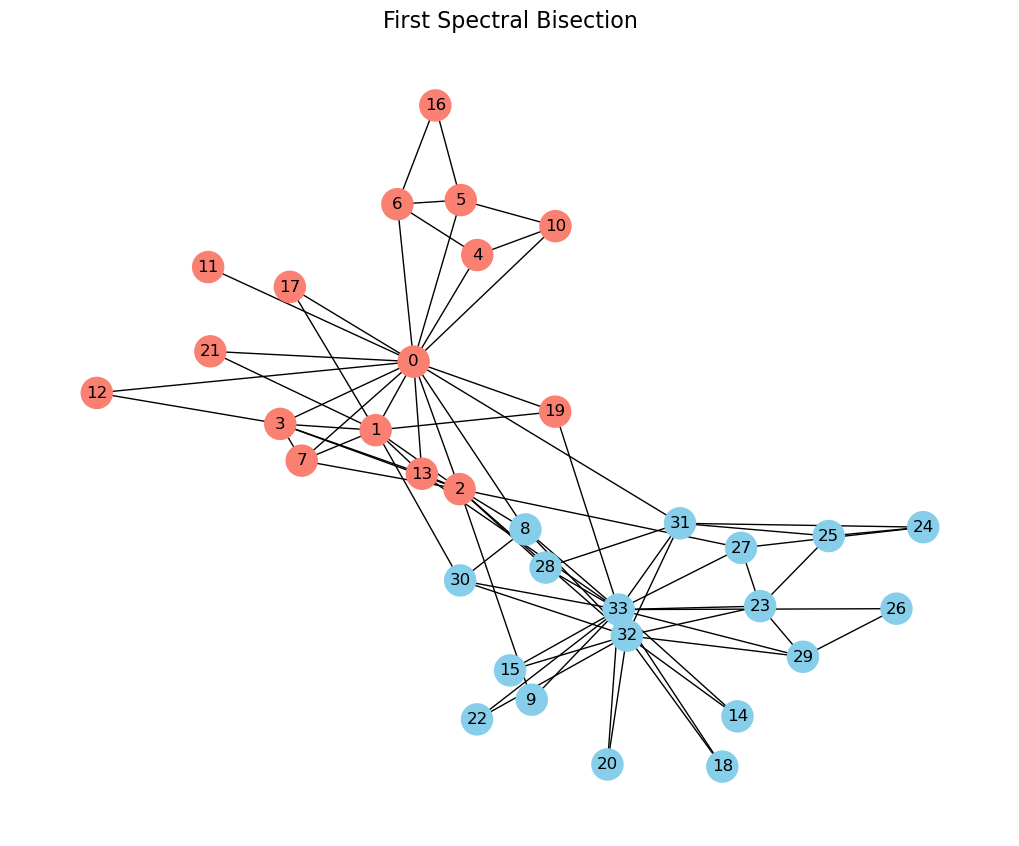

In [12]:
# --- Visualise the First Manual Split ---

# create the fixed layout positions
pos = nx.spring_layout(G, seed=42)

# call the visualisation function with the two communities we've found
print("--- Visualising the first two-way split ---")
visualise_communities(G, pos, [community1, community2], "First Spectral Bisection")

This is how our Karate Club would've been split into two communities.

One following *the club president*, the other following *Mr. Hi*.

---
## Part 2 : Iterative Algorithm to detect all communities in the network

Now, let's automate this process to find if there are multiple communities in our graph.